In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-2eymcxb4
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-2eymcxb4
  Resolved https://github.com/albumentations-team/albumentations to commit 82818a0c4a80924d9f903a656c7f549ec6ca9cb2
  Preparing metadata (setup.py) ... done


# Download Full Dataset

Market-1501 dataset :
https://www.kaggle.com/pengcw1/market-1501

In [2]:
!git clone https://github.com/parth1620/Person-Re-Id-Dataset

fatal: destination path 'Person-Re-Id-Dataset' already exists and is not an empty directory.


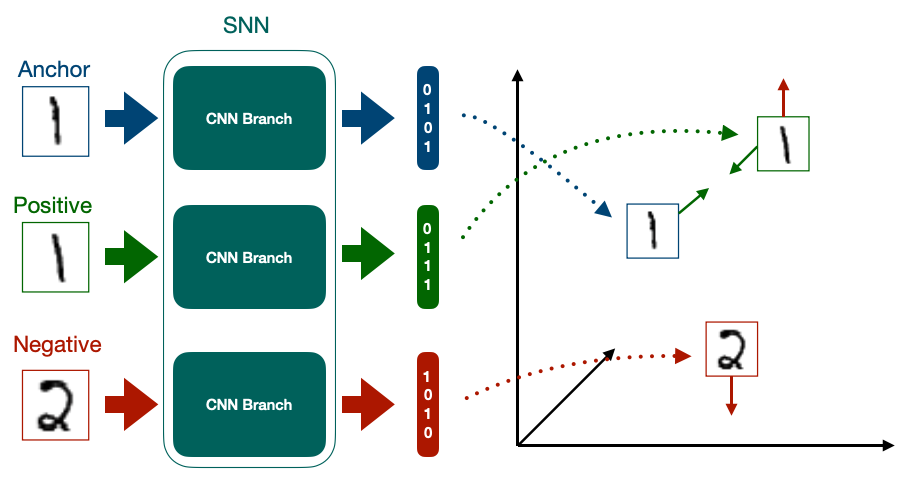

# Imports

In [3]:
import sys
sys.path.append('/content/Person-Re-Id-Dataset')

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import timm

import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader

from skimage import io
from sklearn.model_selection import train_test_split

from tqdm import tqdm

# Configurations

In [5]:
DATA_DIR = '/content/Person-Re-Id-Dataset/train/'
CSV_FILE = '/content/Person-Re-Id-Dataset/train.csv'

BATCH_SIZE = 32
LR = 0.001
EPOCHS = 15

DEVICE = 'cuda'

In [6]:
df = pd.read_csv(CSV_FILE)
df.head()

,Anchor,Negative,Positive
0,1420_c5s3_052165_01.jpg,1334_c6s3_061492_05.jpg,1420_c3s3_051678_01.jpg
1,1420_c3s3_061978_03.jpg,0234_c3s3_079494_02.jpg,1420_c6s3_085567_02.jpg
2,1420_c5s3_062565_05.jpg,0475_c2s1_122816_08.jpg,1420_c3s3_051653_01.jpg
3,1420_c6s3_085592_04.jpg,0662_c2s2_036662_05.jpg,1420_c1s6_013446_04.jpg
4,0663_c5s3_085987_03.jpg,1463_c2s3_098102_02.jpg,0663_c3s3_085544_06.jpg


In [7]:
row = df.iloc[4]

A_img = io.imread(DATA_DIR + row.Anchor)
P_img = io.imread(DATA_DIR + row.Positive)
N_img = io.imread(DATA_DIR + row.Negative)

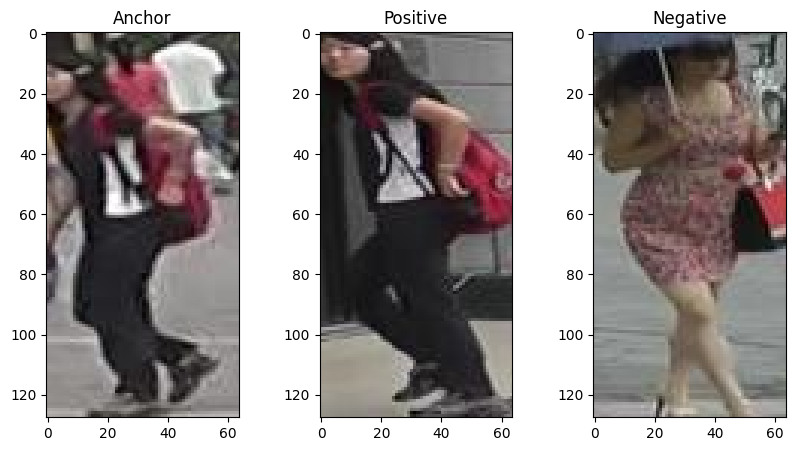

In [8]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (10, 5))

ax1.set_title("Anchor")
ax1.imshow(A_img)

ax2.set_title("Positive")
ax2.imshow(P_img)

ax3.set_title("Negative")
ax3.imshow(N_img)

In [9]:
train_df, valid_df = train_test_split(df, test_size = 0.20, random_state=42)

# Create APN Dataset

In [10]:
class APN_Dataset(Dataset):

  def __init__(self, df):
    self.df = df

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):

    row = self.df.iloc[idx]

    A_img = io.imread(DATA_DIR + row.Anchor)
    P_img = io.imread(DATA_DIR + row.Positive)
    N_img = io.imread(DATA_DIR + row.Negative)

    A_img = torch.from_numpy(A_img).permute(2, 0, 1) / 255.0
    P_img = torch.from_numpy(P_img).permute(2, 0, 1) / 255.0
    N_img = torch.from_numpy(N_img).permute(2,0,1) / 255.0

    return A_img, P_img, N_img

In [11]:
trainset = APN_Dataset(train_df)
validset = APN_Dataset(valid_df)

print(f"Size of trainset : {len(trainset)}")
print(f"Size of validset : {len(validset)}")

Size of trainset : 3200
Size of validset : 800


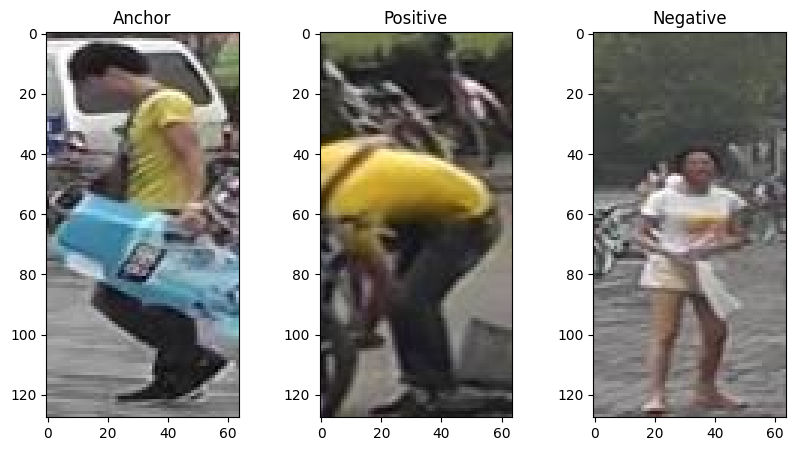

In [12]:
idx = 40
A_img,P_img,N_img = trainset[idx]

f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize= (10,5))

ax1.set_title('Anchor')
ax1.imshow(A_img.numpy().transpose((1,2,0)), cmap = 'gray')

ax2.set_title('Positive')
ax2.imshow(P_img.numpy().transpose((1,2,0)), cmap = 'gray')

ax3.set_title('Negative')
ax3.imshow(N_img.numpy().transpose((1,2,0)), cmap = 'gray')

# Load Dataset into Batches

In [13]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)


In [14]:
print(f"No. of batches in trainloader : {len(trainloader)}")
print(f"No. of batches in validloader : {len(validloader)}")

No. of batches in trainloader : 100
No. of batches in validloader : 25


In [15]:
for A_img, P_img, N_img in trainloader:
  break;

print(f"One image batch shape : {A_img.shape}")

One image batch shape : torch.Size([32, 3, 128, 64])


# Create Model

In [16]:
class APN_Model(nn.Module):

  def __init__(self, emb_size = 512):
    super(APN_Model, self).__init__()

    self.efficientnet = timm.create_model('efficientnet_b0', pretrained = True)
    self.efficientnet.classifier = nn.Linear(in_features=self.efficientnet.classifier.in_features, out_features = emb_size)

  def forward(self, images):
    embeddings =self.efficientnet(images)

    return embeddings

In [17]:
model = APN_Model()
model.to(DEVICE);

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


# Create Train and Eval function

In [18]:
def train_fn(model, dataloader, optimizer, criterion):
  model.train() #ON Dropout
  total_loss = 0.0

  for A_img, P_img, N_img in tqdm(dataloader):
    A_img, P_img, N_img =A_img.to(DEVICE), P_img.to(DEVICE), N_img.to(DEVICE)

    A_embs = model(A_img)
    P_embs = model(P_img)
    N_embs = model(N_img)

    loss = criterion(A_embs, P_embs, N_embs)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(dataloader)

In [19]:
def eval_fn(model, dataloader, criterion):
  model.eval() #OFF Dropout
  total_loss = 0.0
  with torch.no_grad():
    for A_img, P_img, N_img in tqdm(dataloader):
      A_img, P_img, N_img = A_img.to(DEVICE), P_img.to(DEVICE), N_img.to(DEVICE)


      A_embs = model(A_img)
      P_embs = model(P_img)
      N_embs = model(N_img)

      loss = criterion(A_embs, P_embs, N_embs)

      total_loss += loss.item()

    return total_loss / len(dataloader)

In [20]:
criterion = nn.TripletMarginLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

# Create Training Loop

In [21]:
best_valid_loss = np.Inf

for i in range(EPOCHS):

  train_loss = train_fn(model, trainloader, optimizer, criterion)
  valid_loss = eval_fn(model, validloader, criterion)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), "best_model.pt")
    best_valid_loss = valid_loss
    print("SAVED_WEIGHTS_SUCCES")

  print(f"EPOCHS : {i+1} train_loss : {train_loss} valid_loss : {valid_loss}")

100%|██████████| 25/25 [00:03<00:00,  7.35it/s]


SAVED_WEIGHTS_SUCCES
EPOCHS : 1 train_loss : 0.635875332057476 valid_loss : 0.545480745434761


100%|██████████| 25/25 [00:02<00:00, 10.59it/s]


SAVED_WEIGHTS_SUCCES
EPOCHS : 2 train_loss : 0.4096896639466286 valid_loss : 0.46680211544036865


100%|██████████| 25/25 [00:02<00:00, 10.79it/s]


SAVED_WEIGHTS_SUCCES
EPOCHS : 3 train_loss : 0.20932791724801064 valid_loss : 0.2273200696706772


100%|██████████| 25/25 [00:02<00:00, 10.80it/s]


EPOCHS : 4 train_loss : 0.12112642705440521 valid_loss : 0.2525596845149994


100%|██████████| 25/25 [00:02<00:00,  9.20it/s]


EPOCHS : 5 train_loss : 0.07995339512825012 valid_loss : 0.2277703747153282


100%|██████████| 25/25 [00:02<00:00, 10.38it/s]


SAVED_WEIGHTS_SUCCES
EPOCHS : 6 train_loss : 0.0874020279943943 valid_loss : 0.18110615909099578


100%|██████████| 25/25 [00:02<00:00, 10.70it/s]


EPOCHS : 7 train_loss : 0.07697469741106033 valid_loss : 0.21536883175373078


100%|██████████| 25/25 [00:02<00:00,  9.01it/s]


EPOCHS : 8 train_loss : 0.07091779381036759 valid_loss : 0.2523127865791321


100%|██████████| 25/25 [00:02<00:00, 10.57it/s]


EPOCHS : 9 train_loss : 0.06773777350783348 valid_loss : 0.22505318820476533


100%|██████████| 25/25 [00:02<00:00, 10.66it/s]


EPOCHS : 10 train_loss : 0.026692287623882295 valid_loss : 0.24357719779014586


100%|██████████| 25/25 [00:02<00:00, 10.52it/s]


EPOCHS : 11 train_loss : 0.033735095262527465 valid_loss : 0.2065312397480011


100%|██████████| 25/25 [00:02<00:00, 10.77it/s]


EPOCHS : 12 train_loss : 0.04359088510274887 valid_loss : 0.22991072297096252


100%|██████████| 25/25 [00:02<00:00,  8.89it/s]


EPOCHS : 13 train_loss : 0.03606326118111611 valid_loss : 0.19007911920547485


100%|██████████| 25/25 [00:02<00:00, 10.04it/s]


EPOCHS : 14 train_loss : 0.07241819873452186 valid_loss : 0.1988441014289856


100%|██████████| 25/25 [00:02<00:00, 10.71it/s]

EPOCHS : 15 train_loss : 0.057005578577518465 valid_loss : 0.23907874047756195


# Get Anchor Embeddings

In [22]:
def get_encoding_csv(model, anc_img_names):
  anc_img_names_arr = np.array(anc_img_names)
  encodings = []

  model.eval()
  with torch.no_grad():
    for i in tqdm(anc_img_names_arr):
      A_img = io.imread(DATA_DIR + i)
      A_img = torch.from_numpy(A_img).permute(2, 0, 1) / 255.0
      A_img = A_img.to(DEVICE)
      A_enc = model(A_img.unsqueeze(0)) #(c, h, w) -> (l, c, h, w)
      encodings.append(A_enc.squeeze().cpu().detach().numpy())

    encodings = np.array(encodings)
    encodings = pd.DataFrame(encodings)
    df_enc = pd.concat([anc_img_names, encodings], axis = 1)

  return df_enc

In [23]:
model.load_state_dict(torch.load('best_model.pt'))
df_enc = get_encoding_csv(model, df['Anchor'])

100%|██████████| 4000/4000 [00:46<00:00, 86.42it/s]


In [24]:
df_enc.to_csv('database.csv', index = False)
df_enc.head()

,Anchor,0,1,2,3,4,5,6,7,8,...,502,503,504,505,506,507,508,509,510,511
0,1420_c5s3_052165_01.jpg,0.409877,0.604604,0.326784,0.645861,0.287081,-0.240773,-0.578473,0.113119,0.455199,...,-0.572725,0.153797,0.695834,-1.016871,-0.235530,0.357341,0.999072,-0.105535,0.162043,0.067839
1,1420_c3s3_061978_03.jpg,0.397345,0.714205,0.631011,0.448973,0.557447,-0.004549,-0.728684,-0.109591,0.331725,...,-0.976442,-0.062334,0.987398,-1.305354,-0.447266,0.822892,1.410505,-0.076327,0.508590,-0.009344
2,1420_c5s3_062565_05.jpg,0.161671,0.735235,0.510828,0.720766,0.109815,0.039687,-0.227336,0.012491,0.493881,...,-0.605725,0.145334,0.905306,-0.800949,0.194164,0.318715,1.158630,0.076520,0.462231,-0.000307
3,1420_c6s3_085592_04.jpg,0.458083,0.514767,0.706295,0.263812,0.169650,-0.043052,-0.310900,-0.289409,0.231998,...,-1.017789,-0.235099,0.970561,-0.797262,-0.232686,0.572575,1.288357,0.251253,0.709891,-0.303159
4,0663_c5s3_085987_03.jpg,0.423384,0.474819,-0.302769,-0.616765,0.002234,-0.114983,-0.186820,-0.325742,0.350924,...,0.144034,-0.705532,0.461774,0.372916,-0.309246,0.086643,0.517929,0.349023,1.488256,-0.918418


# Inference

In [25]:
def euclidean_dist(img_enc, anc):
    dist = np.sqrt(np.maximum(0, np.dot(img_enc-anc_enc_arr, (img_enc - anc_enc_arr).T)))
    return dist


In [26]:
idx = 0
img_name = df_enc['Anchor'].iloc[idx]
img_path = DATA_DIR +img_name

img = io.imread(img_path)
img = torch.from_numpy(img).permute(2, 0, 1) / 255.0

model.eval()
with torch.no_grad():
  img = img.to(DEVICE)
  img_enc = model(img.unsqueeze(0))
  img_enc = img_enc.detach().cpu().numpy()

In [27]:
anc_enc_arr = df_enc.iloc[:, 1:].to_numpy()
anc_enc_img_names = df_enc['Anchor']

In [28]:
# distance = []

# for i in range(anc_enc_arr.shape[0]):
#   dist = euclidean_dist(img_enc, anc_enc_arr[i : i+1, :])
#   distance = np.append(distance, dist)

distances = np.sqrt(np.sum((anc_enc_arr - img_enc)**2, axis=1))
distance = distances.tolist()


In [29]:
closeset_idx = np.argsort(distance)

/usr/local/lib/python3.10/dist-packages/networkx/drawing/layout.py:724: RuntimeWarning: divide by zero encountered in divide
  costargs = (np, 1 / (dist_mtx + np.eye(dist_mtx.shape[0]) * 1e-3), meanwt, dim)


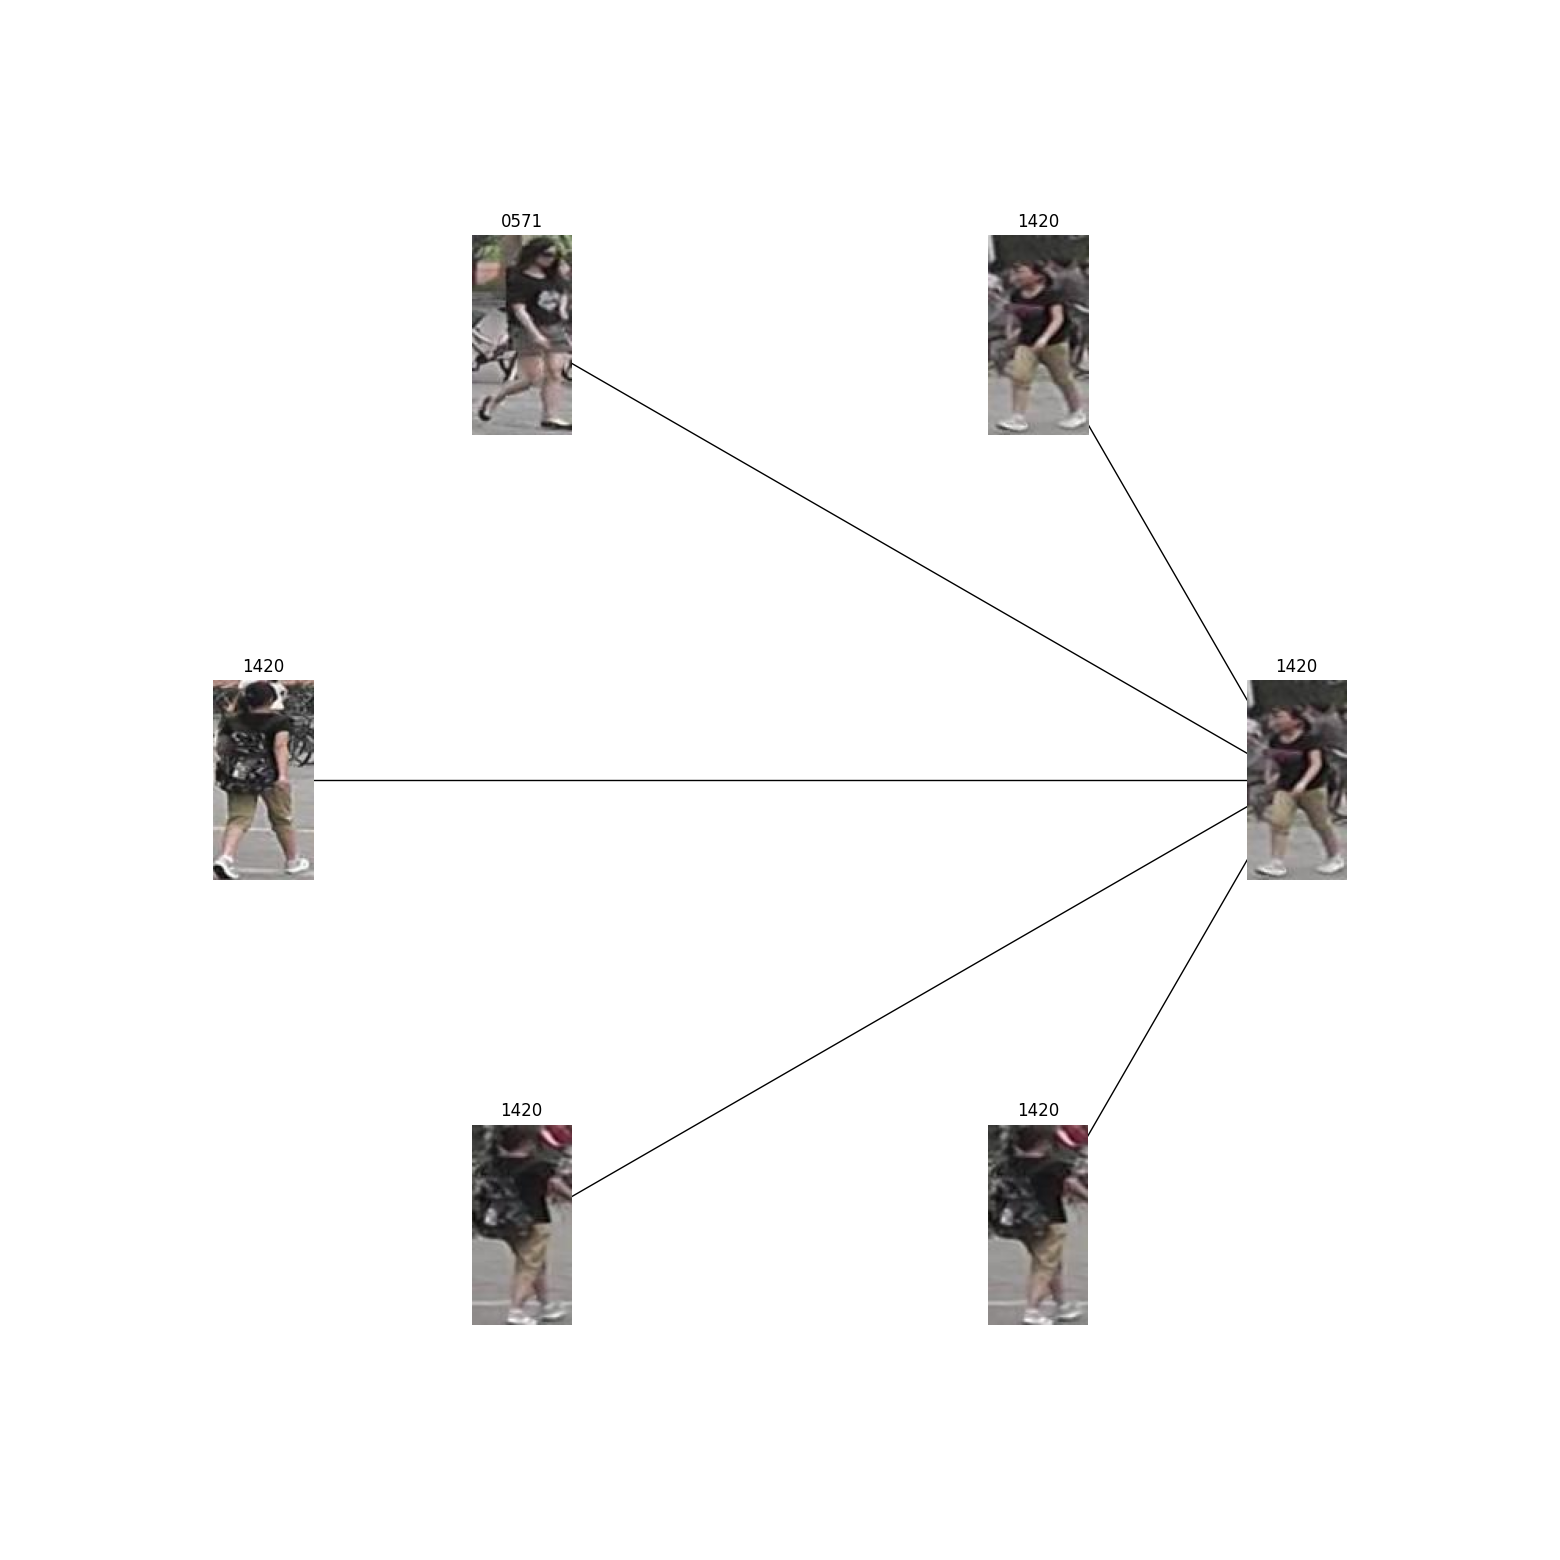

In [32]:
from utils import plot_closest_imgs

plot_closest_imgs(anc_enc_img_names, DATA_DIR, img, img_path, closeset_idx, distance, no_of_closest = 5);